In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import logging
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

%matplotlib inline

### 1. Фиксация генератора случайных чисел

In [5]:
seed = 1910
np.random.seed(seed)

### 2. Загрузка датасета

In [6]:
df = pd.read_excel("C:\Datasets/10_fire_dataset_bin.xlsx")
df.shape

(8166, 22)

In [7]:
df.head()

,Unnamed: 0,area,lon,lat,Dist_str,Dist_railw,Dist_car,T,Po,P,...,DD,Ff,N,WW,Cl,Nh,H,Cm,VV,Td
0,2017-09-24 10:00:00,0,0.0,0.0,0.0,0.0,0.0,9.4,761.9,774.8,...,"Ветер, дующий с востока",2,100%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,600-1000,"Высококучевые просвечивающие, расположенные на...",10.0,4.3
1,2017-09-24 13:00:00,0,0.0,0.0,0.0,0.0,0.0,11.7,762.4,775.2,...,"Ветер, дующий с северо-северо-востока",3,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,3.1
2,2017-09-24 16:00:00,0,0.0,0.0,0.0,0.0,0.0,11.6,762.7,775.6,...,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3
3,2017-09-24 19:00:00,0,0.0,0.0,0.0,0.0,0.0,7.7,763.3,776.4,...,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,1.2
4,2017-09-24 22:00:00,0,0.0,0.0,0.0,0.0,0.0,6.1,763.6,773.7,...,"Ветер, дующий с севера",1,Облаков нет.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3


Редактирование столбца "Unnamed: 0" - остается только month (месяц), тип данных заменяется на object

In [8]:
df['Unnamed: 0'] = df['Unnamed: 0'].dt.month
df.rename({'Unnamed: 0': 'Month'}, axis=1, inplace=True)
df.head()
df['Month'] = df['Month'].astype('object')

Распределение числа пожаров по месяцам

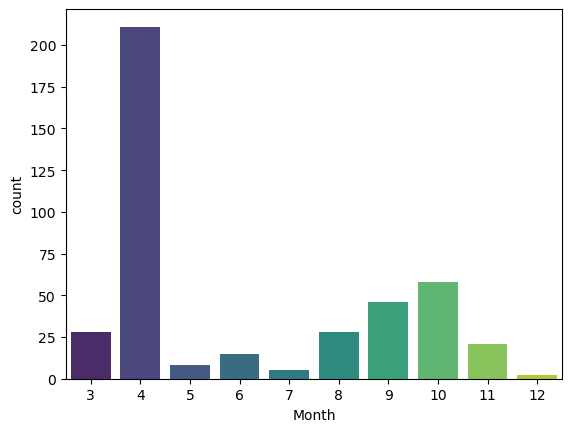

Число пожаров по месяцам (всего пожаров - 422):


,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,28,211,8,15,5,28,46,58,21,2


In [9]:
df_0 = df[df['area']==0]
df_1 = df[df['area']==1]
sns.countplot(data=df_1, x="Month", palette='viridis')
plt.show()

count = [len(df_1[df_1['Month']==k]) for k in range(1, 13)]
df_count = pd.DataFrame([count], columns=range(1, 13))
print(f'Число пожаров по месяцам (всего пожаров - {len(df_1)}):')
df_count

### 3. Балансировка классов - оверсэмплирование

In [10]:
print('Число объектов класса 0 и 1')
print(f'Класс 0: {len(df_0)}, Класс 1: {len(df_1)}')

Число объектов класса 0 и 1
Класс 0: 7744, Класс 1: 422


In [11]:
X_data = df.copy()
y_data = X_data.pop("area")   

ros = RandomOverSampler(random_state = seed) # random_state = 42
X_r, y_r = ros.fit_resample(X_data, y_data)
  
X_r = pd.DataFrame(X_r)
y_r = pd.DataFrame(y_r)
df = pd.concat([y_r, X_r], axis=1, join='inner')

num_0 = len(df[df['area']==0])
num_1 = len(df[df['area']==1])
print(num_0, num_1)

7744 7744


In [12]:
df.describe()

,area,lon,lat,Dist_str,Dist_railw,Dist_car,T,Po,P,Pa,U,Ff,VV,Td
count,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000,15488.000000
mean,0.500000,25.269805,26.574035,18260.496635,8355.642880,286.628120,6.604784,751.229423,764.122346,0.160970,63.034866,1.780475,9.635815,-1.018304
std,0.500016,25.279122,26.578278,28355.776816,12271.022334,474.713006,10.328529,6.668287,6.972215,0.870152,21.398275,0.964590,2.843959,8.790952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23.800000,725.600000,738.600000,-22.000000,12.000000,0.000000,0.200000,-26.200000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,747.300000,759.900000,-0.300000,46.000000,1.000000,10.000000,-7.500000
50%,0.500000,24.076608,25.921746,0.311769,10.271243,0.066578,7.200000,751.600000,764.500000,0.300000,63.000000,2.000000,10.000000,-1.200000
75%,1.000000,50.771435,53.111390,26197.561101,14076.863720,420.349280,13.900000,755.200000,768.200000,0.700000,84.000000,2.000000,10.000000,5.500000
max,1.000000,52.419154,54.624496,139339.388668,53919.346006,3065.928510,36.100000,777.000000,790.900000,25.200000,100.000000,7.000000,50.000000,20.200000


In [13]:
df.describe(include='object')

,Month,DD,N,WW,Cl,Nh,H,Cm
count,15488,15488,15488,2976,15488,15488,15488,15488
unique,12,17,10,79,10,9,6,8
top,4,"Ветер, дующий с запада",Облаков нет.,Снег непрерывный слабый в срок наблюдения.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевые просвечивающие, расположенные на..."
freq,4485,2641,5107,1011,7010,4249,7040,7099


### 4. Feature engineering

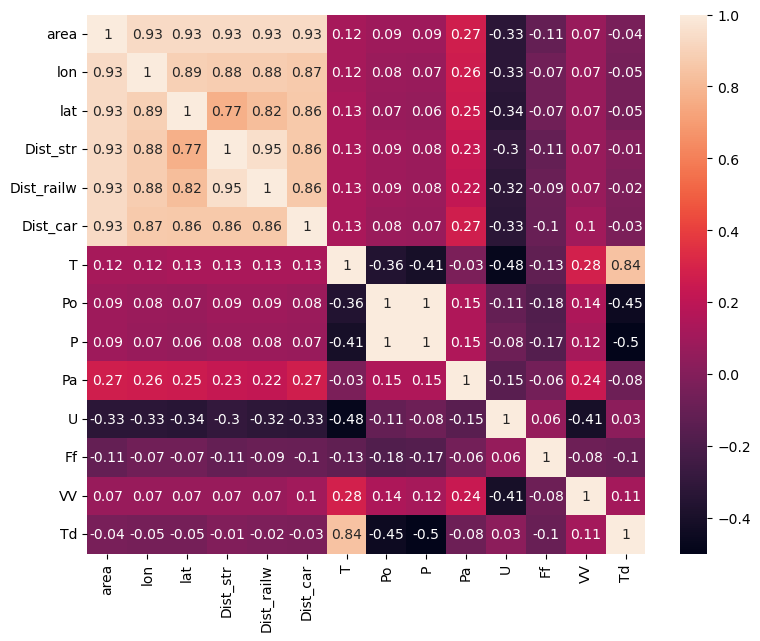

In [14]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(method='spearman').round(2), annot=True)
plt.show()

Удаление коррелированных признаков

In [15]:
df = df.drop(columns=['lon', 'lat', 'Dist_railw', 'Dist_str', 'Dist_car', 'Po', 'Td'])

Удаление части категориальных признаков, кодирование оставшихся

In [16]:
df = df.drop(['Cl', 'Nh', 'H', 'Cm'], axis=1)
df = pd.get_dummies(data=df, prefix='cat_', drop_first=True)
df.shape

(15488, 121)

Коэф. корреляции признаков с целевой переменной area

In [17]:
df.corrwith(df.area).sort_values(ascending=False).round(3) # ascending=False - это сортировка по убыванию

area                                          1.000
cat__4                                        0.449
cat__Облаков нет.                             0.256
Pa                                            0.191
cat__Ветер, дующий с северо-востока           0.178
                                              ...  
cat__Состояние неба в общем не изменилось.   -0.172
cat__2                                       -0.205
cat__12                                      -0.217
cat__100%.                                   -0.253
U                                            -0.329
Length: 121, dtype: float64

Удаление признаков с низким коэф. корреляции

In [18]:
coeff_cor_min = 0.1

features_low = [i for i in df.columns if df.corrwith(df.area).abs()[i] < coeff_cor_min]
print("Удаляемые признаки:")
df[features_low].corrwith(df.area).sort_values(ascending=False).round(3)

Удаляемые признаки:


cat__60%.                                    0.099
cat__Ветер, дующий с северо-северо-запада    0.095
VV                                           0.076
P                                            0.073
cat__9                                       0.067
                                             ...  
cat__Дымка.                                 -0.084
cat__90  или более, но не 100%              -0.086
cat__Ветер, дующий с юго-востока            -0.086
cat__11                                     -0.091
cat__Ветер, дующий с востоко-юго-востока    -0.098
Length: 101, dtype: float64

In [19]:
df = df.drop(features_low, axis=1)
X = df.copy()
y = X.pop("area")

print('Оставшиеся признаки')
df.corrwith(df.area).sort_values(ascending=False).round(3) # ascending=False - это сортировка по убыванию

Оставшиеся признаки


area                                          1.000
cat__4                                        0.449
cat__Облаков нет.                             0.256
Pa                                            0.191
cat__Ветер, дующий с северо-востока           0.178
cat__Ветер, дующий с севера                   0.143
cat__Ветер, дующий с северо-северо-востока    0.135
T                                             0.122
cat__Ветер, дующий с северо-запада           -0.106
cat__Ветер, дующий с юго-юго-запада          -0.111
cat__20–30%.                                 -0.117
Ff                                           -0.128
cat__5                                       -0.130
cat__Ветер, дующий с западо-юго-запада       -0.138
cat__7                                       -0.145
cat__Состояние неба в общем не изменилось.   -0.172
cat__2                                       -0.205
cat__12                                      -0.217
cat__100%.                                   -0.253
U           

### 5. Разбиение датасета на train и test, масштабирование признаков

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=seed)
sc = StandardScaler() # RobustScaler() StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### 6. Параметры OPTUNA, обучение моделей

In [21]:
# Установка уровня журналирования для Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['CatBoostClassifier', 'LGBMClassifier', 'XGBClassifier'])

    if classifier_name == 'CatBoostClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = CatBoostClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed, silent=True)

    elif classifier_name == 'LGBMClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = LGBMClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed, silent=True)

    elif classifier_name == 'XGBClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed)

    classifier.fit(X_train_std, y_train)
    y_pred = classifier.predict(X_test_std)
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=100)

best_params = study.best_params

classifier_name = best_params['classifier']

if classifier_name == 'CatBoostClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    n_estimators = best_params['n_estimators']
    classifier = CatBoostClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed, silent=True)

elif classifier_name == 'LGBMClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    n_estimators = best_params['n_estimators']
    classifier = LGBMClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed, silent=True)

elif classifier_name == 'XGBClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    n_estimators = best_params['n_estimators']
    classifier = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, random_state=seed)

classifier.fit(X_train_std, y_train)
y_pred = classifier.predict(X_test_std)
y_pred_train = classifier.predict(X_train_std)

print("Лучший классификатор:", classifier_name)
print("Лучшие параметры:", best_params)
print(f'Число верно классифицированных случаев: {(y_test == y_pred).sum()} из {X_test_std.shape[0]}')

Лучший классификатор: LGBMClassifier
Лучшие параметры: {'classifier': 'LGBMClassifier', 'learning_rate': 0.06277087144192925, 'max_depth': 8, 'n_estimators': 750}
Число верно классифицированных случаев: 4620 из 4647


### 7. Метрики

In [22]:
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train).round(5)}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred).round(5)}\n')
print(f'Precision Train: {precision_score(y_train, y_pred_train).round(5)}')
print(f'Precision Test: {precision_score(y_test, y_pred).round(5)}\n')
print(f'Recall Train: {recall_score(y_train, y_pred_train).round(5)}')
print(f'Recall Test: {recall_score(y_test, y_pred).round(5)}\n')
print(f'F1 Train: {f1_score(y_train, y_pred_train).round(5)}')
print(f'F1 Test: {f1_score(y_test, y_pred).round(5)}\n')

Accuracy Train: 0.99105
Accuracy Test: 0.99419

Precision Train: 0.98242
Precision Test: 0.98851

Recall Train: 1.0
Recall Test: 1.0

F1 Train: 0.99113
F1 Test: 0.99422



### 8. График ROC-AUC

ROC-AUC Train: 0.99685
ROC-AUC Test: 0.99103


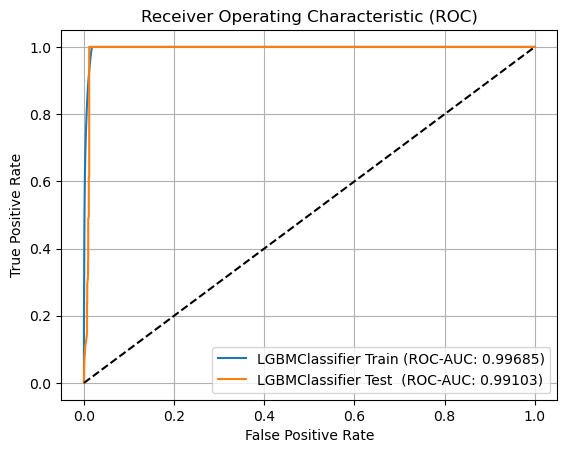

In [23]:
y_pred_train_score = classifier.predict_proba(X_train_std)
y_pred_score = classifier.predict_proba(X_test_std)
roc_auc_train = roc_auc_score(y_train, y_pred_train_score[:,1])
roc_auc_test = roc_auc_score(y_test, y_pred_score[:,1])

print(f'ROC-AUC Train: {roc_auc_train.round(5)}')
print(f'ROC-AUC Test: {roc_auc_test.round(5)}')

# Создание общей области для графиков
fig, ax = plt.subplots()

# ROC-кривая для обучающей выборки
y_pred_proba_train = classifier.predict_proba(X_train_std)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
roc_display_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, estimator_name=f"{classifier_name} Train (ROC-AUC: {roc_auc_train:.5f})")
roc_display_train.plot(ax=ax)

# ROC-кривая для тестовой выборки
y_pred_proba_test = classifier.predict_proba(X_test_std)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_display_test = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, estimator_name=f"{classifier_name} Test  (ROC-AUC: {roc_auc_test:.5f})")
roc_display_test.plot(ax=ax)

ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc='lower right')  # Перемещение легенды в правый нижний угол
plt.plot([0, 1], [0, 1], "k--")
ax.grid(True)  # Добавление линий сетки
plt.show()

### 9. Матрица ошибок (Confusion Matrix)

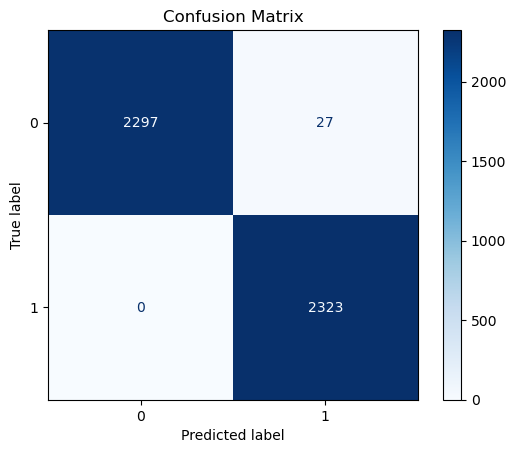

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()